In [93]:
from ThesisPackage.Environments.soccer.soccer_env_multi import SoccerGame
from ThesisPackage.Environments.pong.multi_pong_language_continuous import PongEnv
from ThesisPackage.RL.Seperated_PPO_soccer.multi_ppo import PPO_Multi_Agent
from ThesisPackage.RL.Decentralized_PPO.util import concatenate_agent_observations, split_agent_actions
from ThesisPackage.RL.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
from ThesisPackage.Wrappers.frame_stack import ParallelFrameStack
from ThesisPackage.Wrappers.vecWrapper import PettingZooVectorizationParallelWrapper
import torch
import time
import numpy as np

In [94]:
def team_split(data, team_agents, teams):
    split_data = {team: concatenate_agent_observations({agent: torch.Tensor(content) for agent, content in data.items() if agent in team_agents[team]}) for team in teams}
    return split_data

In [95]:
def make_env():
    env = SoccerGame(20, 12, sequence_length=2, vocab_size=3, noise_team=-1)
    env = ParallelFrameStack(env, 4)
    return env

In [96]:
def load():
    num_envs = 2
    seed = 1
    total_timesteps = 1000000
    envs = PettingZooVectorizationParallelWrapper(make_env, num_envs)

    test_env = SoccerGame(20, 12, sequence_length=2, vocab_size=3, noise_team=1)
    test_env = ParallelFrameStack(test_env, 4)
    # envs = [make_env(seed, vocab_size, sequence_length, max_episode_steps) for i in range(num_envs)]
    # agent = PPO_Multi_Agent(envs, test_env=test_env, device="cpu")
    agent = PPO_Multi_Agent(envs, test_env=test_env, device="cpu")
    agent.load_models_from_zip("/Users/cowolff/Documents/GitHub/ma.pong_rl/models/soccer_2vs2_trained.zip")
    return agent

In [97]:
num_steps = 10000
agent = load()
env = make_env()

Process Process-18:
Process Process-17:
Traceback (most recent call last):
  File "/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/ThesisPackage/Wrappers/vecWrapper.py", line 22, in worker
    cmd, data = remote.recv()
  File "/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/multiprocessing/connection.py", line 383, in _recv
    raise EOFError
EOFError
Traceback (most recent call last):
  File "/Users/cowolff/

In [98]:
obs, info = env.reset()
action = {}

obs = {agent: np.expand_dims(content, axis=0) for agent, content in obs.items()}
obs = team_split(obs, agent.team_agents, agent.teams)
obs[1] = torch.tensor(obs[1], dtype=torch.float32, requires_grad=True)

action = agent.agents[1].actor(obs[1])

action.backward(torch.ones_like(action))

saliency = obs[1].grad.data.abs()

saliency = saliency.numpy()

print(saliency.shape)

(2, 64)


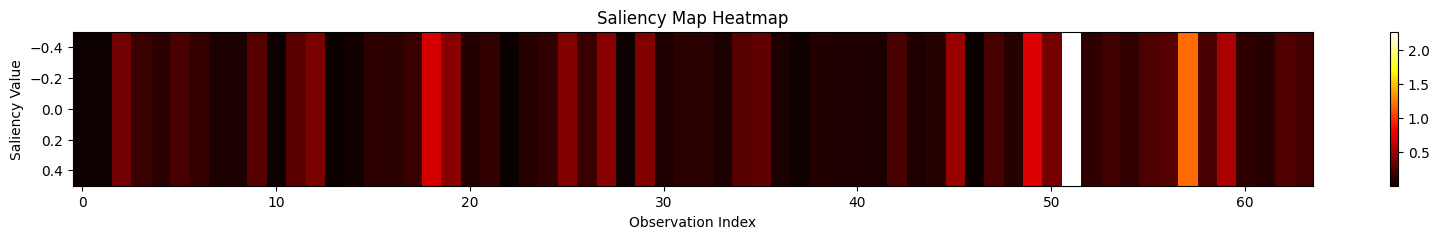

In [99]:
import matplotlib.pyplot as plt

# Reshape the 1D saliency map to a 2D array (1 row x N columns)
saliency_map_2d = saliency[0].reshape(1, -1)

# Plot the saliency map as a 2D heatmap
plt.figure(figsize=(20, 2))  # Adjust figure size to make it more readable
plt.imshow(saliency_map_2d, cmap='hot', aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('Saliency Map Heatmap')
plt.xlabel('Observation Index')
plt.ylabel('Saliency Value')
plt.show()


In [100]:
# split the observation in 4 equal parts
unstacked_saliencies = np.split(saliency[0], 4)
unstacked_saliencies = np.stack(unstacked_saliencies, axis=0)
print(np.average(unstacked_saliencies[:, -1 * env.sequence_length:]))

0.12430572


In [101]:
saliencies = {cur_team: [] for cur_team in env.teams}
obs, info = env.reset()
while True:
    obs = {agent: np.expand_dims(content, axis=0) for agent, content in obs.items()}
    obs = team_split(obs, agent.team_agents, agent.teams)

    obs_track = {cur_agent: torch.tensor(obs[cur_agent], dtype=torch.float32, requires_grad=True) for cur_agent in obs.keys()}
    logits = {cur_team: agent.agents[cur_team].actor(obs_track[cur_team]) for cur_team in obs_track.keys()}

    next_obs = {agent: torch.tensor(cur_obs, dtype=torch.float32) for agent, cur_obs in obs.items()}

    with torch.no_grad():
        action_dict = {}
        for team in agent.teams:
            action, _, _, _ = agent.agents[team].get_action_and_value(next_obs[team])
            action = action.cpu().numpy()
            team_agent_actions = split_agent_actions(action, agent.team_agents[team])
            action_dict.update(team_agent_actions)
    action_dict = {agent: action_dict[agent][0] for agent in action_dict}

    for team in logits.keys():
        logits[team].backward(torch.ones_like(logits[team]))

        saliency = obs_track[team].grad.data.abs()

        saliency = saliency.numpy()

        unstacked_saliencies = np.split(saliency[0], 4)
        unstacked_saliencies = np.stack(unstacked_saliencies, axis=0)
        average_language = np.average(unstacked_saliencies[:, -1 * env.sequence_length:])

        saliencies[team].append(average_language)

    obs, _, truncations, terminations, infos = env.step(action_dict)

    if any([truncations[agent] or terminations[agent] for agent in env.agents]):
        break

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


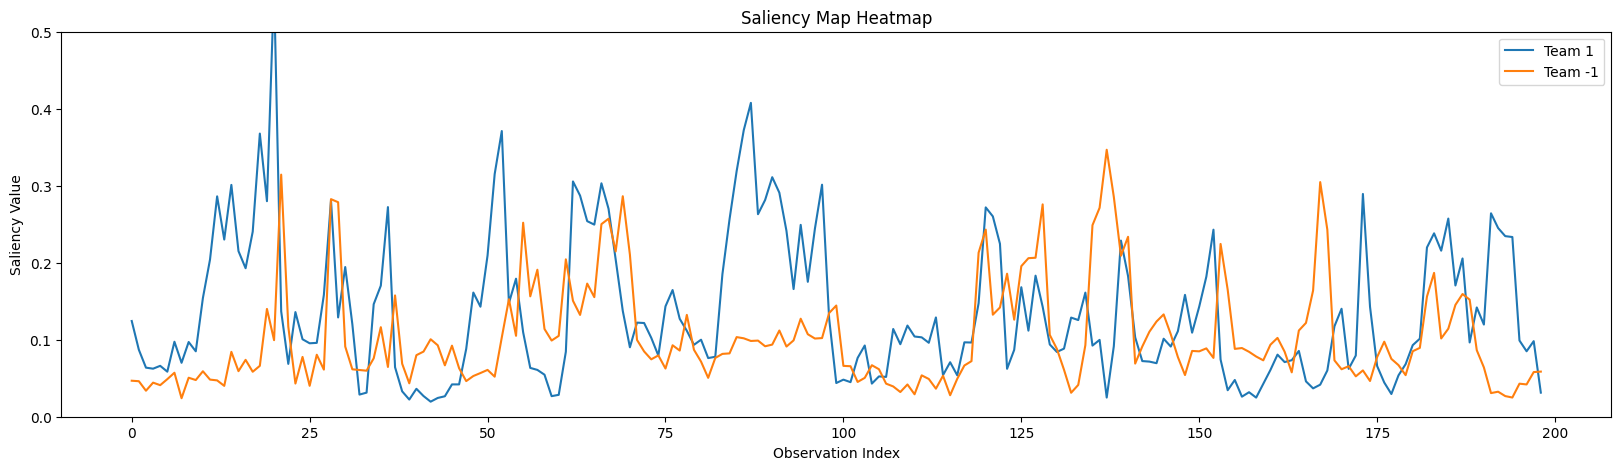

In [102]:
plt.figure(figsize=(20, 5))  # Adjust figure size to make it more readable
ax = plt.gca()
for i, team in enumerate(saliencies.keys()):
    plt.plot(saliencies[team], label=f"Team {team}")
plt.title('Saliency Map Heatmap')
plt.xlabel('Observation Index')
plt.ylabel('Saliency Value')
ax.set_ylim(0, 0.5)
plt.legend()
plt.show()